# Compare my density projection with Paola's
Exact match (up to round-off error 1e-15) is when using the following variation of the projection function. And with res=(800,800,100), box_size=big_box, selection=snap.mask_density() (removing den<1e-19). 

This notebook leaves OUT the density mask. Therefore we see some difference in low density area.

In [40]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import matplotlib.pyplot as plt
import unyt as u

import richio
richio.plots.use_nice_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Box sizes

In [41]:
beta = 1
mstar = .5 * richio.units.mscale
rstar = .47 * richio.units.lscale
mbh = 10**4 * richio.units.mscale
rt = rstar * (mbh/mstar)**(1/3)

ra = rt**2 / rstar #2 * Rt * (Mbh/mstar)**(1/3)

nozzle_box = u.unyt_array([-3*rt, -3*rt, -2*ra, 3*rt, 3*rt, 2*ra])
big_box = u.unyt_array([-6*ra, -4*ra, -2*ra, 2.5*ra, 3*ra, 2*ra])
# else_box = u.unyt_array([-3*ra, -2*ra, -0.8*ra, 2*ra, 2*ra, 0.8*ra])

Read data (won't read the data to ram now)

In [42]:
path1 = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_21'
path2 = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_76'
path3 = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_118'

snap1 = richio.load(path1)
snap2 = richio.load(path2)
snap3 = richio.load(path3)

## Plot
Do the star mask to match what paola did

In [ ]:
# Monkey patch the projection function, exact same as Paola's
from numpy.typing import ArrayLike
from typing import Any
from matplotlib.colors import Colormap

def projection(
    self,
    data: str | ArrayLike,
    res: int | ArrayLike,
    x: str | ArrayLike = "X",
    y: str | ArrayLike = "Y",
    z: str | ArrayLike = "Z",
    box_size: ArrayLike | None = None,
    unit_system: str = "cgs",
    ax: Any | None = None,
    selection: ArrayLike = None,
    cmap: str | Colormap = "twilight",
    label_latex: str = "\\Sigma",
    unit_latex: str | None = None,
    **kwargs,
):
    """
    Make a projection plot. To make use of the unit system, use either str
    keys or unyt_array data for `data`, `x`, `y`, `z`, `box_size`.
    """
    # Fetch data
    data = self._get_data(data)
    x = self._get_data(x)
    y = self._get_data(y)
    z = self._get_data(z)

    # Select cells
    if selection is not None:
        data = data[selection]
        x = x[selection]
        y = y[selection]
        z = z[selection]

    # Set boxsize
    if box_size is None:
        x0, y0, z0, x1, y1, z1 = self.snap.box  # Load the box size
    else:
        x0, y0, z0, x1, y1, z1 = box_size

    # Set resolution
    try:
        nx, ny, nz = res[0], res[1], res[2]
    except TypeError:
        nx = ny = nz = res

    # Make Euclidean grid
    xspace = np.linspace(x0, x1, nx)  # disable endpoints such that dz = (z1-z0)/res instead of (z1-z0)/(res-1)
    yspace = np.linspace(y0, y1, ny)                                                #PM: endpoint=True
    zspace = np.linspace(z0, z1, nz)

    X, Y, Z = np.meshgrid(xspace, yspace, zspace, indexing="ij")

    coords = np.stack([x, y, z], axis=-1)  # coordinates of the particles
    grid_coords = np.stack([X, Y, Z], axis=-1)  # coordinates of the grid (query points)

    i = richio.plots._kdtree_interpolate(coords=coords, grid_coords=grid_coords)

    grid_data = data[i]

    dz = (z1 - z0) / (nz-1)                                                      #PM: dz = (z1 - z0) / (nz - 1)
    projected_data = np.sum(grid_data[:, :, :-1] * dz, axis=-1).in_base(unit_system)#PM: grid_data[:, :, :-1]

    if ax is None:
        fig, ax = plt.subplots()

    # Plot
    xgrid, ygrid = np.meshgrid(xspace, yspace, indexing="ij")
    im = ax.pcolormesh(xgrid, ygrid, np.log10(projected_data), cmap=cmap, **kwargs)

    if unit_latex is None:      # read the unit from data if not specified
        unit_latex = projected_data.units.latex_repr
        
    plt.colorbar(im, ax=ax, label=f"$\\log[{label_latex}/{unit_latex}]$")

    return ax, projected_data

# Monkey patching
richio.plots.SnapshotPlotter.projection = projection

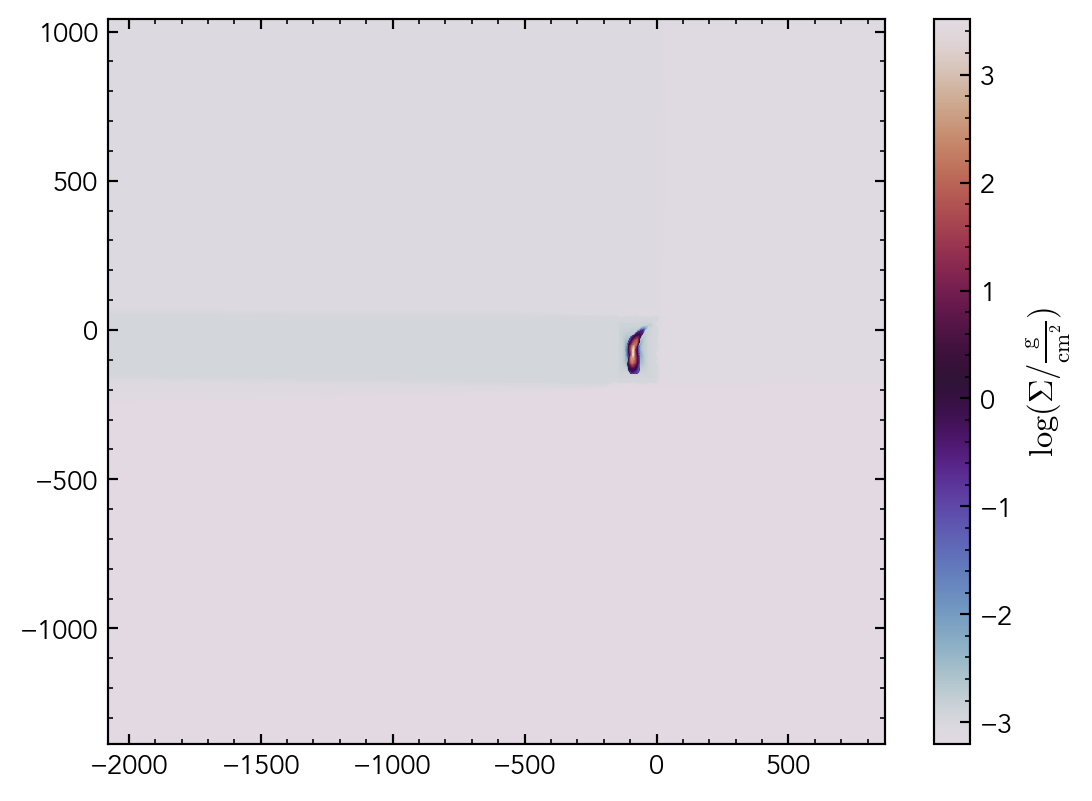

In [43]:
ax, proj_data1 = snap1.plots.projection(data='density', 
                                           x='CMx', 
                                           y='CMy', 
                                           z='CMz', 
                                           res=(800, 800, 100),
                                           box_size=big_box,
                                        #    selection = snap1.mask_density()
                                           )
plt.show()

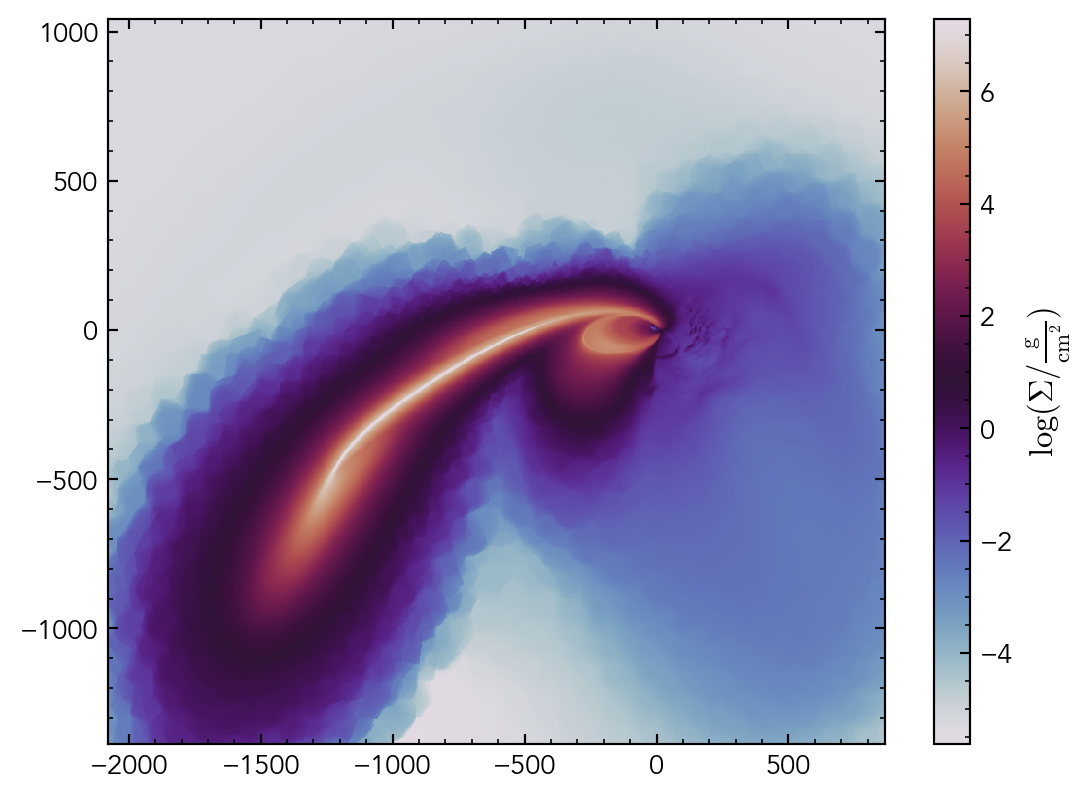

In [44]:
ax, proj_data2 = snap2.plots.projection(data='density', 
                                           x='CMx', 
                                           y='CMy', 
                                           z='CMz', 
                                           res=(800, 800, 100),
                                           box_size=big_box,
                                        #    selection = snap2.mask_density()
                                           )
plt.show()

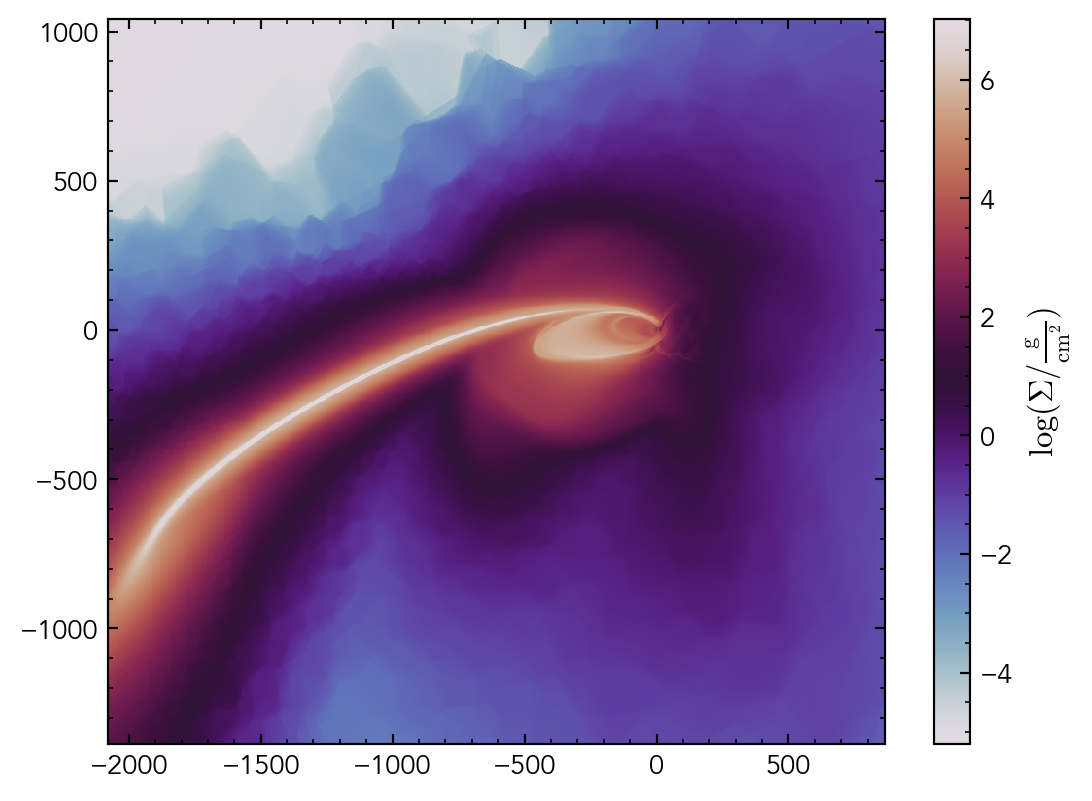

In [45]:
ax, proj_data3 = snap3.plots.projection(data='density', 
                                           x='CMx', 
                                           y='CMy', 
                                           z='CMz', 
                                           res=(800, 800, 100),
                                           box_size=big_box,
                                        #    selection=snap3.mask_density()
                                           )

### Compared to Paola's

In [46]:
unit_column_den = richio.units.mscale/richio.units.lscale**2

In [47]:
proj_data_p1 = np.load('/home/hey4/rich_tde/data/external/bigDenproj21.npy') * unit_column_den
proj_data_p2 = np.load('/home/hey4/rich_tde/data/external/bigDenproj76.npy') * unit_column_den
proj_data_p3 = np.load('/home/hey4/rich_tde/data/external/bigDenproj118.npy') * unit_column_den

In [48]:
# plt.imshow(np.log10(proj_data_p1.T), origin='lower', cmap='twilight')

6.661338147750939e-16 dimensionless 7.105427357601002e-15 dimensionless 0.0 dimensionless


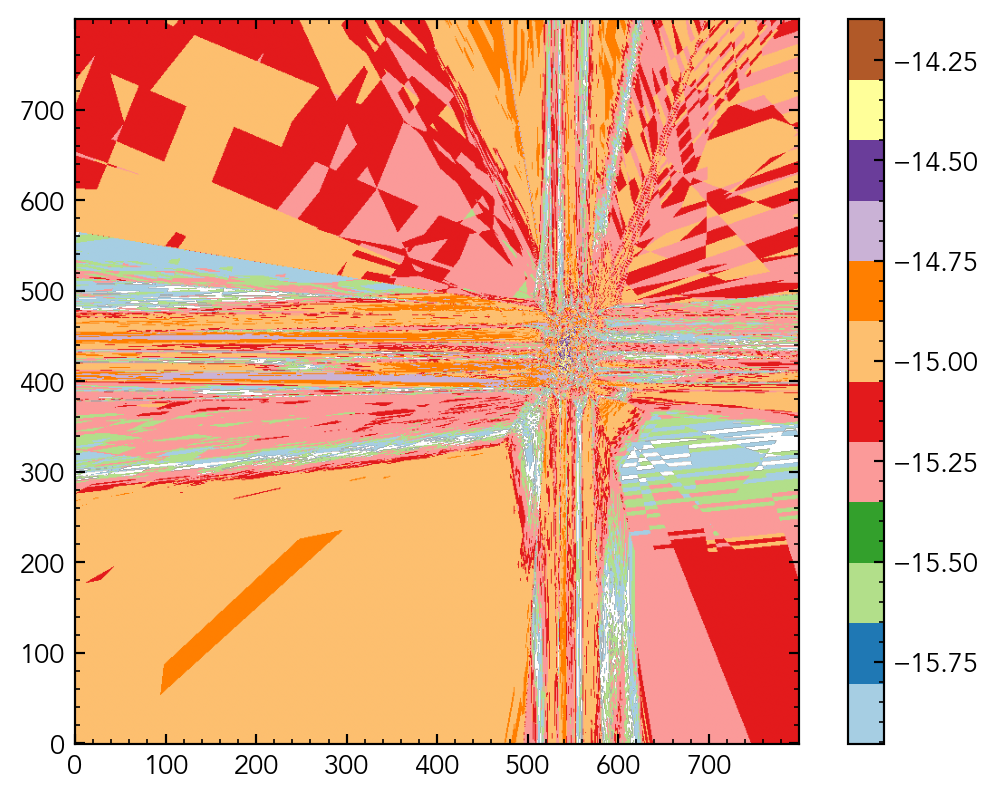

In [52]:
diff1 = np.abs(proj_data1 / proj_data_p1 - 1)
plt.imshow(np.log10(diff1.T), origin='lower', cmap='Paired')
plt.colorbar()
print(np.median(diff1), np.max(diff1), np.min(diff1))

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


0.011190549675579031 dimensionless 0.9981661006437409 dimensionless


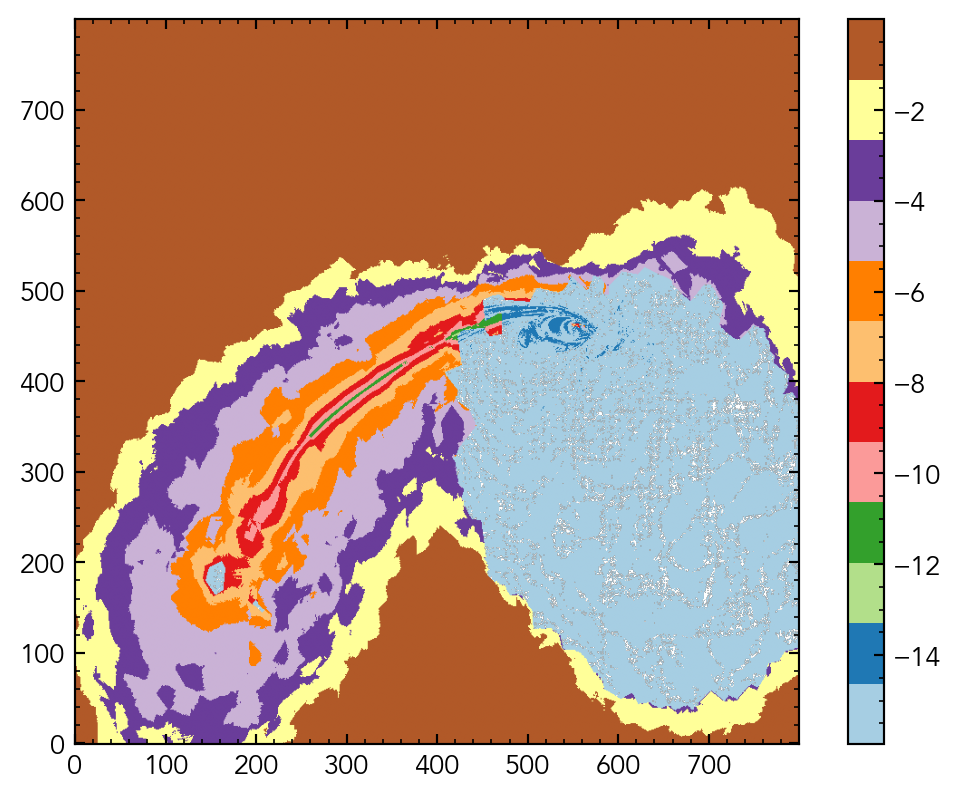

In [54]:
diff2 = np.abs(proj_data2 / proj_data_p2 - 1)
plt.imshow(np.log10(diff2.T), origin='lower', cmap='Paired')
plt.colorbar()
print(np.median(diff2), np.max(diff2))

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


5.551115123125783e-16 dimensionless 0.9874183556660519 dimensionless


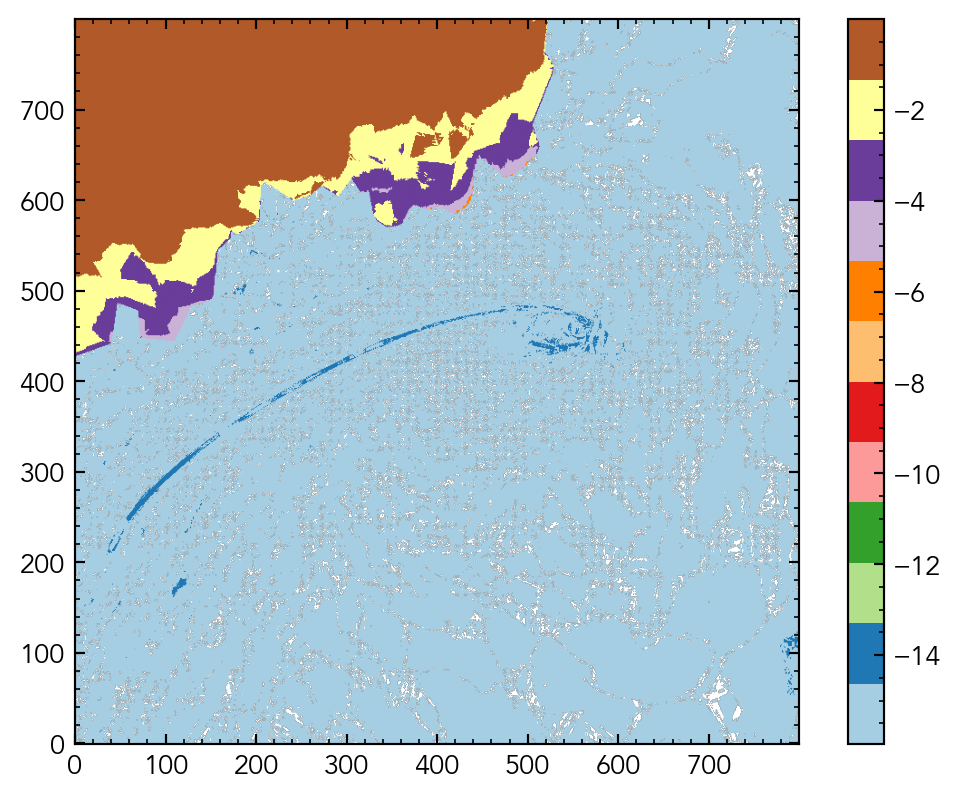

In [55]:
diff3 = np.abs(proj_data3 / proj_data_p3 - 1)
plt.imshow(np.log10(diff3.T), origin='lower', cmap='Paired')
plt.colorbar()
print(np.median(diff3), np.max(diff3))